# **Rejection Evaluation**
***

## **Seed 10**
***

We trained resnet50 on RSNAPneumonia dataset. This is a binary classification task which classifies chest X-ray images as either sick or normal. Let's take a look at the results dataframe:

In [1]:
import pandas as pd
output_path = r"C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\outputs_train\RSNAPneumonia\resnet50\dropout_all_layers_autolr_paper\seed_10\failure_detection\scores_df.csv"
scores_df = pd.read_csv(output_path)
scores_df.head()

,Targets,Predictions,IsCorrect,Probas,Threshold,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,...,Laplace_threshold,Laplace_score,Laplace_probas,TrustScore,ConfidNet_scores,SWAG_probas,SWAG_targets,SWAG_predictions,SWAG_threshold,SWAG_score
0,0,False,True,0.006509,0.2514,0.993491,-0.013104,0.989641,False,0.010359,...,0.257537,0.977948,0.022052,1.302095,0.993790,0.004734,0,False,0.299343,0.995266
1,1,False,False,0.004871,0.2514,0.995129,-0.009789,0.992970,False,0.007030,...,0.257537,0.979635,0.020365,1.613619,0.995934,0.022046,1,False,0.299343,0.977954
2,0,False,True,0.017060,0.2514,0.982940,-0.034702,0.983886,False,0.016114,...,0.257537,0.964553,0.035447,1.372737,0.981188,0.056983,0,False,0.299343,0.943017
3,0,False,True,0.024324,0.2514,0.975676,-0.049829,0.974338,False,0.025662,...,0.257537,0.955047,0.044953,1.478028,0.972065,0.047792,0,False,0.299343,0.952208
4,0,False,True,0.014682,0.2514,0.985318,-0.029794,0.981458,False,0.018542,...,0.257537,0.967387,0.032613,1.515524,0.981107,0.013802,0,False,0.299343,0.986198


Let's see what columns do we have in here:

In [2]:
scores_df.columns

Index(['Targets', 'Predictions', 'IsCorrect', 'Probas', 'Threshold',
       'Baseline', 'doctor_alpha', 'mcmc_soft_scores', 'mcmc_predictions',
       'mcmc_probas', 'mcmc_entropy_scores', 'Laplace_targets',
       'Laplace_predictions', 'Laplace_threshold', 'Laplace_score',
       'Laplace_probas', 'TrustScore', 'ConfidNet_scores', 'SWAG_probas',
       'SWAG_targets', 'SWAG_predictions', 'SWAG_threshold', 'SWAG_score'],
      dtype='object')

The dataframe consists of the following columns:
* Targets - Our GT classes.
* Predictions - The predicted classes
* IsCorrect - Is that classification correct or not?
* Probas - the probability of making a prediction.
* Threshold - The decision threshold that will yield the FPR as closest to 0.2 as possible.
* Baseline - Baseline softmax scorer.
* doctor_alpha - It is a scorer that quantifies the likelihood of being misclassified , and thus negative (as stated in the article).
* mcmc-soft-scores, mcmc-entropy scores - From the paper: "MC-dropout (MC): Gal & Ghahramani (2016) showed that training a neural network with dropout
regularization (Srivastava et al., 2014) produces a Bayesian approximation of the posterior, where the
approximation is obtained by Monte-Carlo sampling of the network’s parameters i.e. by applying
dropout at test-time and averaging the outputs over several inference passes. The confidence in
the prediction can then be approximated by the negative entropy of the outputs; or by taking the
softmax confidence score on the averaged outputs."
* mcmc predictions - predictions made by using Monte-Carlo sampling on the network's parameters.
* mcmc_probas - probabilities of the predictions for monte-carlo sampling.
* Laplace_targets - The targets for the laplace method. They are the same as the general targets.
* Laplace predictions - predictions made by Laplace
* Laplace threshold - In Laplace score, for binary classification problem, it computes the ROC curve for the validation set, and searches for the threshold that will yield a False Positive Rate as close as possible to 0.2. That threshold is saved in that column.
* Laplace score -Laplace confidence score
* Laplace_probas - probabilities of laplace predictions (classifying 0 or 1)
* TrustScore - Score made by TrustScore scorer.
* ConfidNet scores- scores made by ConfidNet
* SWAG_probas - probabilities of SWAG predictions (classifying 0 or 1)
* SWAG_targets - targets for SWAG method. The same as the general targets.
* SWAG_predictions - The predictions made by SWAG
* SWAG threshold - In SWAG score, for binary classification problem, it computes the ROC curve for the validation set, and searches for the threshold that will yield a False Positive Rate as close as possible to 0.2. That threshold is saved in that column.
* SWAG_score - SWAG confidence scores

We used The Baseline scorer, doctor-alpha, MC- softmax, MC- entropy, Laplace, TrustScore, ConfidNet, and SWAG (8 overall). The ones missing (as compared to the paper) are DUQ (which we failed to train due to insufficient CUDA memory) and ensemble (we used only 1 seed so ensemble is irrelevant). Let's check for sure that all target columns are identical:


In [3]:
# Lowercase the column names before checking
lower_case_columns = [col.lower() for col in scores_df.columns]

# Find all columns containing the word 'target'
target_columns = [col for col in scores_df.columns if 'target' in col.lower()]

# Compare the values between target columns
are_identical = all(scores_df[target_columns[0]].equals(scores_df[col]) for col in target_columns[1:])

if are_identical:
    print(f"All target columns are identical: {target_columns}")
else:
    differing_columns = [col for col in target_columns if not scores_df[target_columns[0]].equals(scores_df[col])]
    differences = {col: scores_df[[target_columns[0], col]].drop_duplicates() for col in differing_columns}
    print(f"Columns that differ: {differing_columns}")
    print(f"Differences: {differences}")

All target columns are identical: ['Targets', 'Laplace_targets', 'SWAG_targets']


So, Now we can begin the thresholding procedure:

### **Thresholding**
***

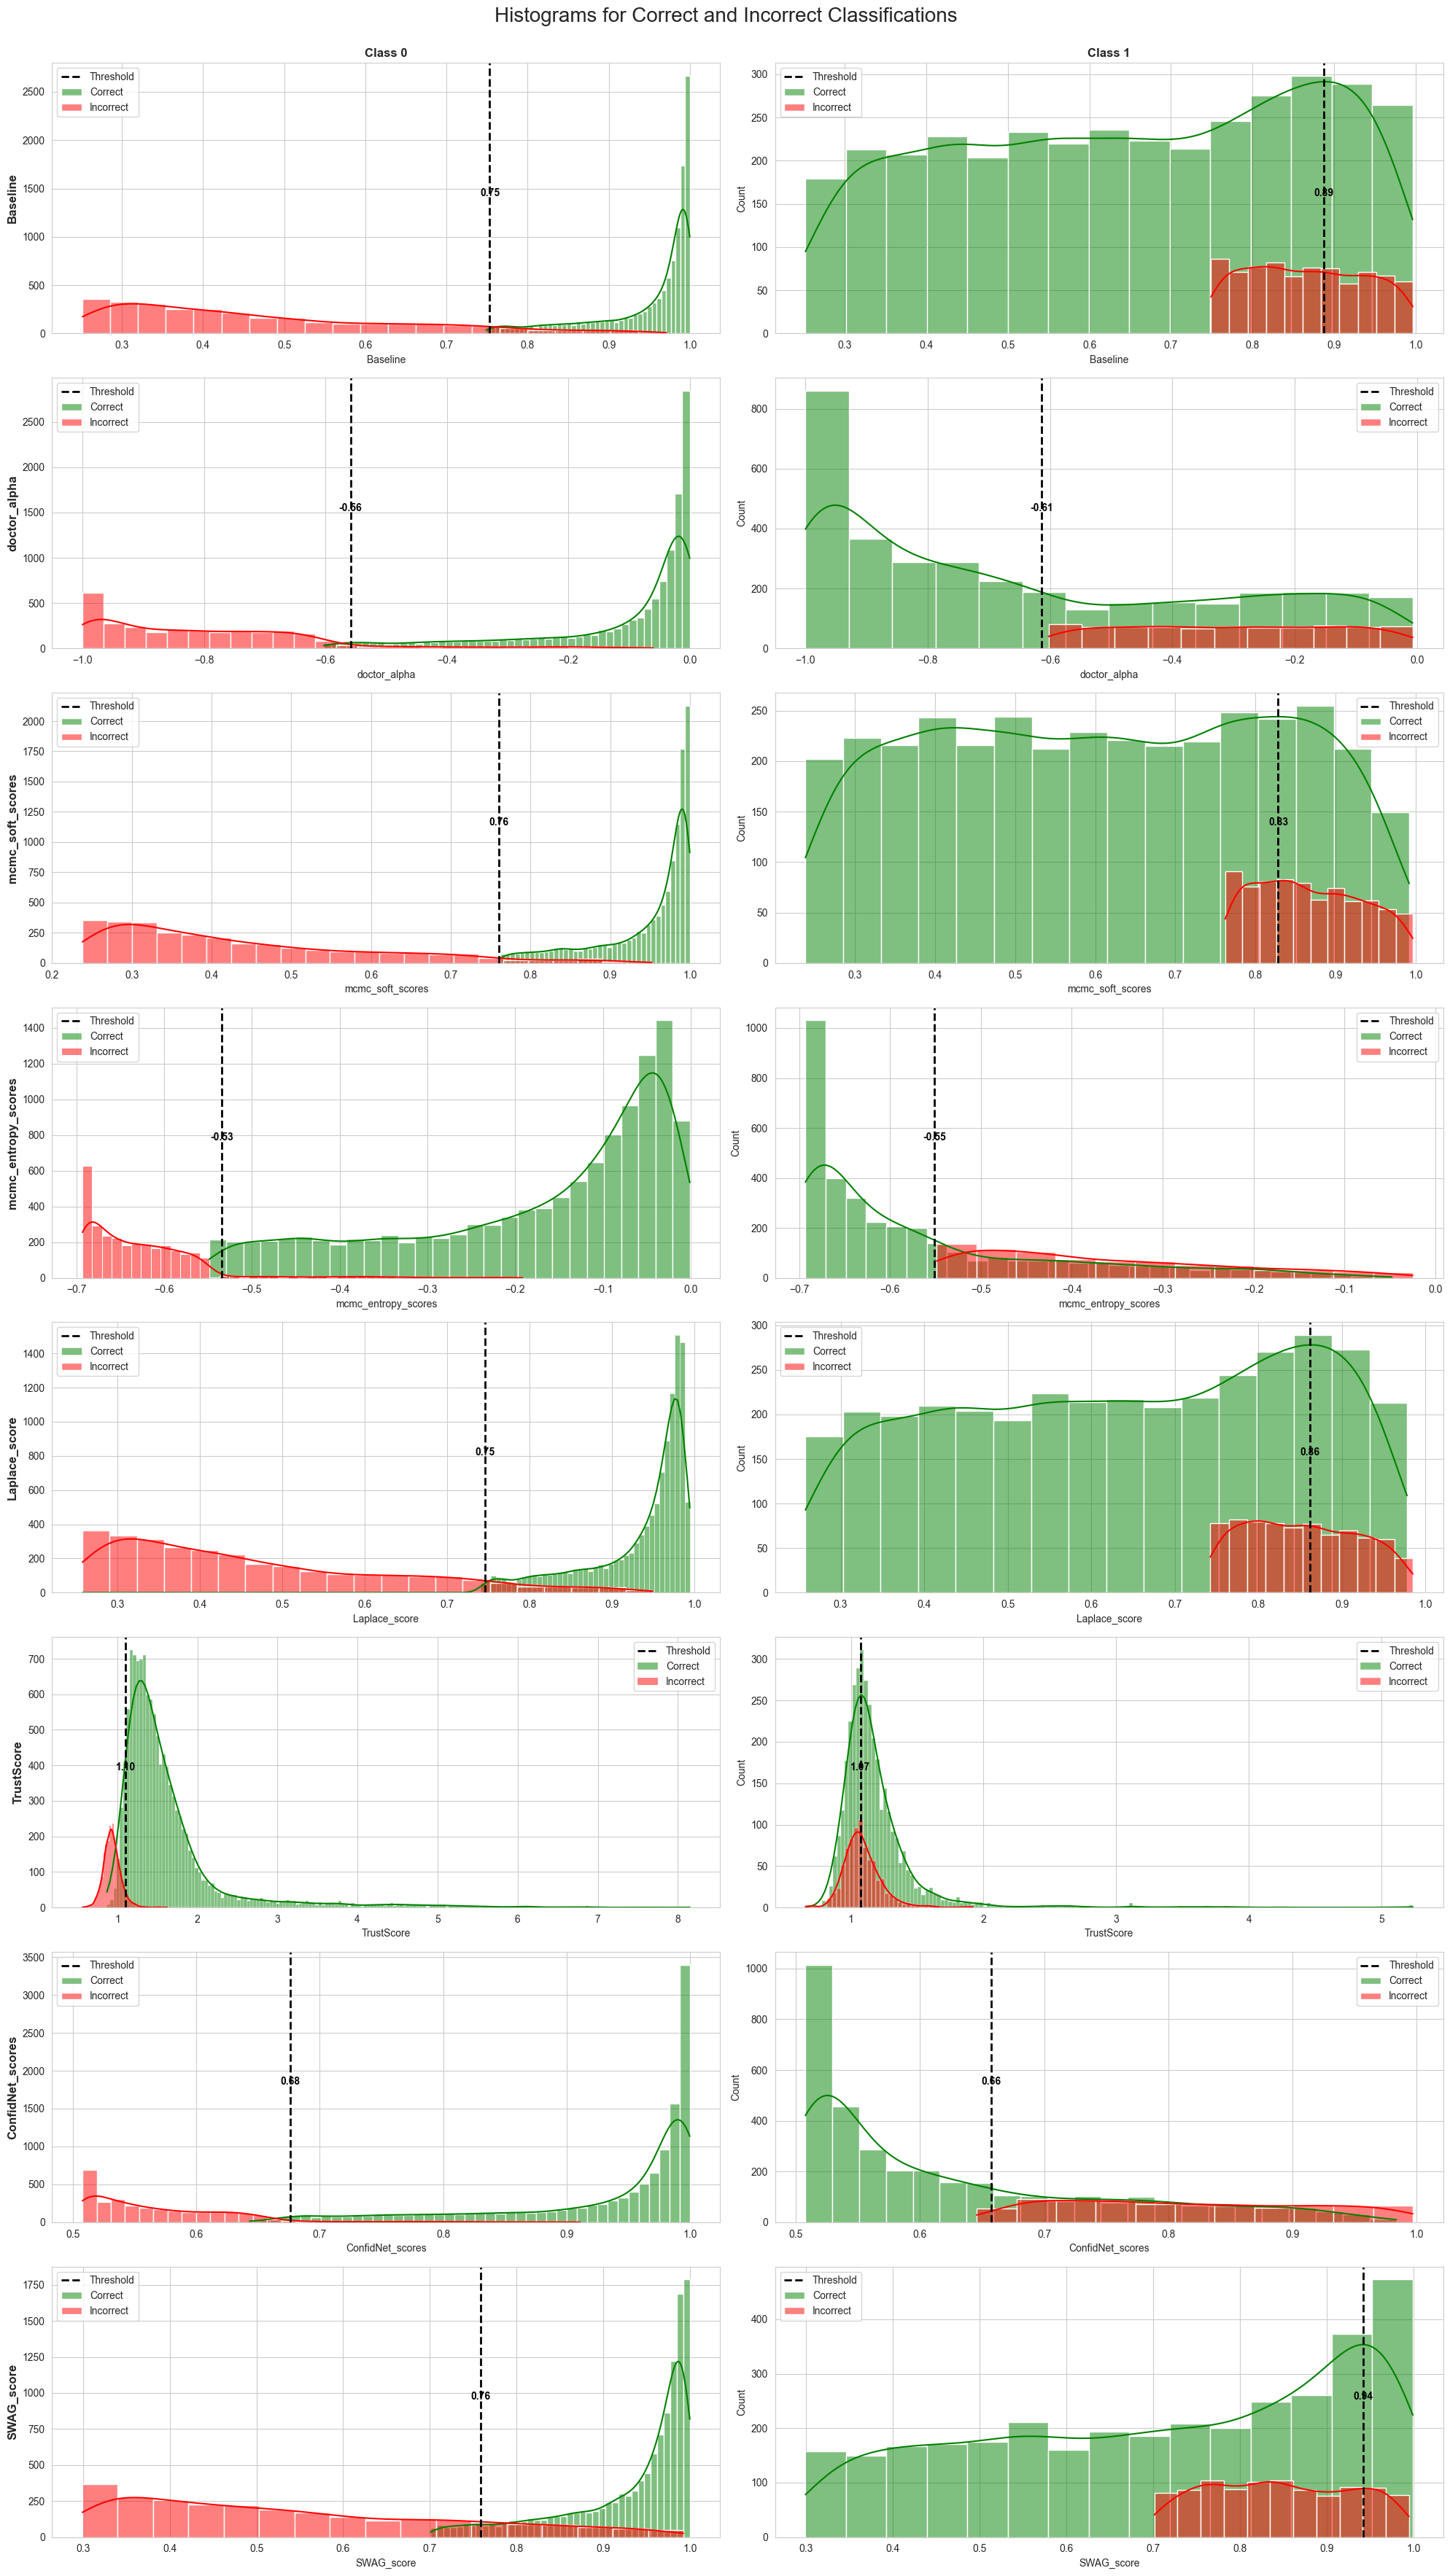

,Seed,Scoring_Method,Class,Threshold
0,10,Baseline,0,0.753408
1,10,Baseline,1,0.887523
2,10,doctor_alpha,0,-0.558637
3,10,doctor_alpha,1,-0.613683
4,10,mcmc_soft_scores,0,0.760434
5,10,mcmc_soft_scores,1,0.828312
6,10,mcmc_entropy_scores,0,-0.534464
7,10,mcmc_entropy_scores,1,-0.551094
8,10,Laplace_score,0,0.745659
9,10,Laplace_score,1,0.862160


In [4]:
from rejection.thresholding import find_thresholds
thresholds_with_class_separation = find_thresholds(scores_df,visualize=True, separate_classes=True,confidnet=True, swag=True)
thresholds_with_classes_separation_dict = {"Seed": len(thresholds_with_class_separation.keys()) * [10],
                                           "Scoring_Method":[method for method, _ in thresholds_with_class_separation.keys()],
                                           "Class":[cls for _, cls in thresholds_with_class_separation.keys()],"Threshold":thresholds_with_class_separation.values()}
thresholds_with_class_separation_df = pd.DataFrame(thresholds_with_classes_separation_dict)
display(thresholds_with_class_separation_df)

We can see that the classes separation resulted in a great overlap between the histograms in a way that will make it difficult to find a threshold that separates between them (Especially when dealing with class 1 - The sick chests!). Instead, let's try to drop the classes separation:

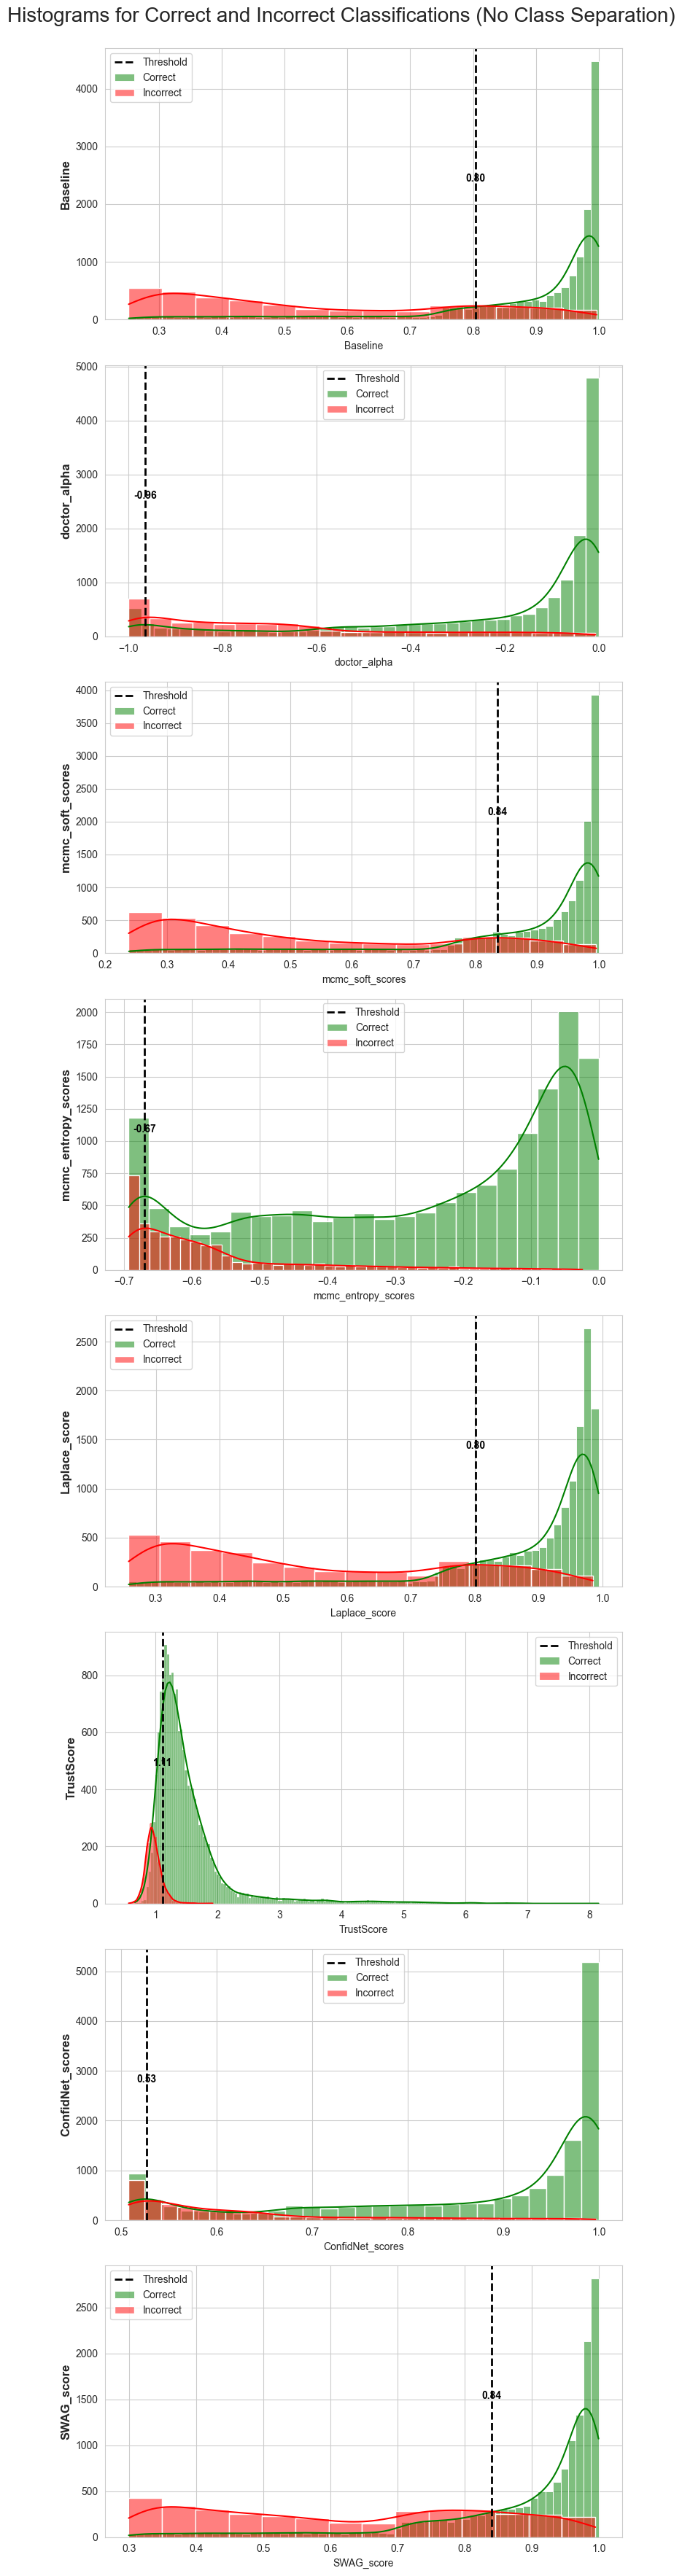

,Seed,Scoring_Method,Threshold
0,10,Baseline,0.804357
1,10,doctor_alpha,-0.964971
2,10,mcmc_soft_scores,0.835938
3,10,mcmc_entropy_scores,-0.670280
4,10,Laplace_score,0.800960
5,10,TrustScore,1.110883
6,10,ConfidNet_scores,0.526341
7,10,SWAG_score,0.840661


In [5]:
thresholds_without_class_separation = find_thresholds(scores_df, visualize=True, separate_classes=False, confidnet=True,
                                                   swag=True)
thresholds_without_classes_separation_dict = {"Seed": len(thresholds_without_class_separation.keys()) * [10],
                                           "Scoring_Method": [method for method in
                                                              thresholds_without_class_separation.keys()],
                                           "Threshold": thresholds_without_class_separation.values()}
thresholds_without_class_separation_df = pd.DataFrame(thresholds_without_classes_separation_dict)
display(thresholds_without_class_separation_df)

Still the Trustscore and the mcmc_entropy does not give us a good separation, so we will just drop them:


In [6]:
# Drop the rows where Scoring_Method is 'TrustScore' or 'mcmc_entropy_scores'
filtered_thresholds_without_class_separation_df = thresholds_without_class_separation_df[
    ~thresholds_without_class_separation_df['Scoring_Method'].isin(['TrustScore', 'mcmc_entropy_scores'])
]
filtered_thresholds_without_class_separation_df = filtered_thresholds_without_class_separation_df.reset_index(drop=True)
display(filtered_thresholds_without_class_separation_df)

,Seed,Scoring_Method,Threshold
0,10,Baseline,0.804357
1,10,doctor_alpha,-0.964971
2,10,mcmc_soft_scores,0.835938
3,10,Laplace_score,0.800960
4,10,ConfidNet_scores,0.526341
5,10,SWAG_score,0.840661


In [7]:
# Find all columns containing the word 'predictions' (case-insensitive)
prediction_columns = [col for col in scores_df.columns if 'predictions' in col.lower()]
print(prediction_columns)

['Predictions', 'mcmc_predictions', 'Laplace_predictions', 'SWAG_predictions']


### **Find optimal weights for the scores**
***


In [8]:
from rejection.confidence_score import find_optimal_weights
weights_df = find_optimal_weights(dataframe=scores_df,thresholds=filtered_thresholds_without_class_separation_df)
display(weights_df)

,Scoring_Method,Threshold,Rejection_Direction,Weight
0,Baseline,0.804357,<,0.929358
1,doctor_alpha,-0.964971,<,0.000000
2,mcmc_soft_scores,0.835938,<,1.000000
3,Laplace_score,0.800960,<,0.953626
4,ConfidNet_scores,0.526341,<,0.099195
5,SWAG_score,0.840661,<,0.925130


In [9]:
from rejection.confidence_score import calculate_confidence_score
confidence_scores_df = calculate_confidence_score(dataframe=scores_df,weights=weights_df)
display(confidence_scores_df)

,Targets,Predictions,IsCorrect,Probas,Threshold,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,...,Laplace_score,Laplace_probas,TrustScore,ConfidNet_scores,SWAG_probas,SWAG_targets,SWAG_predictions,SWAG_threshold,SWAG_score,Confidence_score
0,0,False,True,0.006509,0.2514,0.993491,-0.013104,0.989641,False,0.010359,...,0.977948,0.022052,1.302095,0.993790,0.004734,0,False,0.299343,0.995266,98.755495
1,1,False,False,0.004871,0.2514,0.995129,-0.009789,0.992970,False,0.007030,...,0.979635,0.020365,1.613619,0.995934,0.022046,1,False,0.299343,0.977954,98.424871
2,0,False,True,0.017060,0.2514,0.982940,-0.034702,0.983886,False,0.016114,...,0.964553,0.035447,1.372737,0.981188,0.056983,0,False,0.299343,0.943017,95.997801
3,0,False,True,0.024324,0.2514,0.975676,-0.049829,0.974338,False,0.025662,...,0.955047,0.044953,1.478028,0.972065,0.047792,0,False,0.299343,0.952208,95.369021
4,0,False,True,0.014682,0.2514,0.985318,-0.029794,0.981458,False,0.018542,...,0.967387,0.032613,1.515524,0.981107,0.013802,0,False,0.299343,0.986198,97.499299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19207,0,True,False,0.293808,0.2514,0.293808,-0.709313,0.288514,True,0.288514,...,0.300983,0.300983,0.886064,0.615325,0.247034,0,False,0.299343,0.752966,18.818579
19208,1,True,True,0.817377,0.2514,0.817377,-0.425604,0.789037,True,0.789037,...,0.804249,0.804249,1.116862,0.664460,0.859529,1,True,0.299343,0.859529,74.400540
19209,0,False,True,0.185878,0.2514,0.814122,-0.434010,0.810569,False,0.189431,...,0.797936,0.202064,1.193444,0.737593,0.142548,0,False,0.299343,0.857452,75.031161
19210,0,True,False,0.373254,0.2514,0.373254,-0.879243,0.389804,True,0.389804,...,0.376663,0.376663,0.928102,0.549441,0.466618,0,True,0.299343,0.466618,17.963925


In [12]:
confidence_scores_df["Confidence_score"].min()

0.0